**Table of contents**<a id='toc0_'></a>    
- [Imports, Constants, and Reading Data](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Constants](#toc1_2_)    
  - [Read Data](#toc1_3_)    
- [Breakdown of the Number of VMs and CPU-hours based on VM sizes](#toc2_)    
- [Normalized Average CPU Utilization CDF](#toc3_)    
- [Kurtosis](#toc4_)    
- [Kurtosis of a server packed with different BVM traces](#toc5_)    
- [Breakdown of the Number of VMs and CPU-hours based on VM lifetimes](#toc6_)    
- [CDF of the Percentage of all Running VMs that are long-running at any 5-minute sampling point](#toc7_)    
- [Comparing Server Capacity Violations and Utilization for different algorithms](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports, Constants, and Reading Data](#toc0_)

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns
import matplotlib.colors as mcolors
from datetime import timedelta
from timeit import default_timer as timer
import itertools
import matplotlib.patches as patches
from scipy.stats import kurtosis

In [2]:
from pylab import rcParams
size = 20
sns.set_theme()
params = {'figure.figsize':(15, 7),
            "axes.labelweight": "bold",
            'legend.fontsize': size* 1.2,
            'axes.labelsize': size*1.25,
            'axes.titlesize': size*1.25,
            'xtick.labelsize': size * 0.75,
            'ytick.labelsize': size * 0.75,
            'xtick.labelsize': size*1.2,
            'ytick.labelsize': size*1.2,
            'axes.titlepad': 25}
plt.rcParams.update(params)
sns.set_style("whitegrid")

## <a id='toc1_2_'></a>[Constants](#toc0_)

In [42]:
# CONSTANTS
ds_names = ['2021_burstable', '2019_burstable', '2021_regular']
# x/y axis Labels to be used in the figures
metric_name_to_axis_label = {'%cpu_usage_average':'Utilization(%)',
                             'perc_time_violations':'Violation Rate (%)',
                             'prob_violation': 'Distribution of Porbability of Violation for a Server'}
# Label to be used in the figures
label_to_algorithm = {'2Xbaseline': "ProviderX\nbaseline", 'rc': 'RC', 'Genie-aided\nbaseline coef.':'Oversubscription\nOracle',
                       'CLT':'CLT', 'Audible':'Audible'}
# BVM Configurations
BVM = namedtuple('VM', 'baseline corecount ram init_credits credit_cap price name')
bvm_configs = [
    BVM(3.37, 20,  80, 600, 4860, 0.992, 'Standard_B20ms'),        # B20MS
    BVM(2.70, 16,  64, 480, 3888, 0.794, 'Standard_B16ms'),        # B16MS
    BVM(2.02, 12,  48, 360, 2909, 0.595, 'Standard_B12ms'),        # B12MS
    BVM(1.35,  8,  32, 240, 1944, 0.397, 'Standard_B8ms'),        # B8MS
    BVM(0.90,  4,  16, 120, 1296, 0.198, 'Standard_B4ms'),        # B4MS
    BVM(0.60,  2,   8,  60,  864, 0.0992, 'Standard_B2ms'),        # B2MS
    BVM(0.40,  2,   4,  60,  576, 0.0496, 'Standard_B2s'),        # B2S
    BVM(0.20,  1,   2,  30,  288, 0.0248, 'Standard_B1ms'),        # B1MS
    BVM(0.10,  1,   1,  30,  144, 0.0124, 'Standard_B1s'),        # B1S
    BVM(0.05,  1, 0.5,  30,   72, 0.0062, 'Standard_B1ls'),        # B1LS
    BVM(0.90,  4,  16, 120, 1296, 0.198, 'Standard_B4hms'),        # B4hMS
    BVM(0.60,  2,   8,  60,  864, 0.0992, 'Standard_B2hms')        # B2hMS
]
baseline_to_corecount = {c.baseline:c.corecount for c in bvm_configs}

# for plots
ds_to_color = dict(zip(ds_names, ['b', 'g', 'r']))
ds_to_ls = dict(zip(ds_names, ['-', '-.', '--']))
algo_to_color = dict(zip(['audible', 'oversubscription-azure', 'oversubscription-oracle', 'clt', 'rc'], ['r', 'b', 'b', 'g', 'c']))
algo_to_ls = dict(zip(['audible', 'oversubscription-azure', 'oversubscription-oracle', 'clt', 'rc'], ['-', ':', '-.', '--', (0, (3, 5, 1, 5, 1, 5))]))

## <a id='toc1_3_'></a>[Read Data](#toc0_)

In [4]:
trace_dataframes = {}
for ds_name in tqdm(ds_names):
    trace_dataframes[ds_name] = pd.read_parquet('data/{}VMs_{}_Data.parquet'.format(ds_name.split('_')[1].title(), ds_name.split('_')[0]))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [05:22<00:00, 107.40s/it]


In [5]:
for ds_name in ds_names:
    trace_dataframes[ds_name]['num_samples'] = trace_dataframes[ds_name]['trace'].apply(len)

# <a id='toc2_'></a>[Breakdown of the Number of VMs and CPU-hours based on VM sizes](#toc0_)

In [6]:
for ds_name in ds_names:
    max_trace_len = 864 if '2019' in ds_name else 2016
    size_str = 'baseline' if 'burstable' in ds_name else 'corecount'
    if 'burstable' in ds_name:
        trace_dataframes[ds_name]['allocated_corehours_from_ns'] = trace_dataframes[ds_name].apply(lambda row: max(row['trace'].size, max_trace_len)*row[size_str]*2 , axis=1)/12
    else:
        trace_dataframes[ds_name]['allocated_corehours_from_ns'] = trace_dataframes[ds_name].apply(lambda row: max(row['trace'].size, max_trace_len)*row[size_str] , axis=1)/12
    trace_dataframes[ds_name]['utilized_corehours_from_ns'] = trace_dataframes[ds_name]['trace'].apply(np.sum)/12

In [7]:
for ds_name in ds_names:
    if 'burstable' in ds_name:
        trace_dataframes[ds_name]['corecount'] = trace_dataframes[ds_name]['baseline'].apply(lambda b: baseline_to_corecount[b])

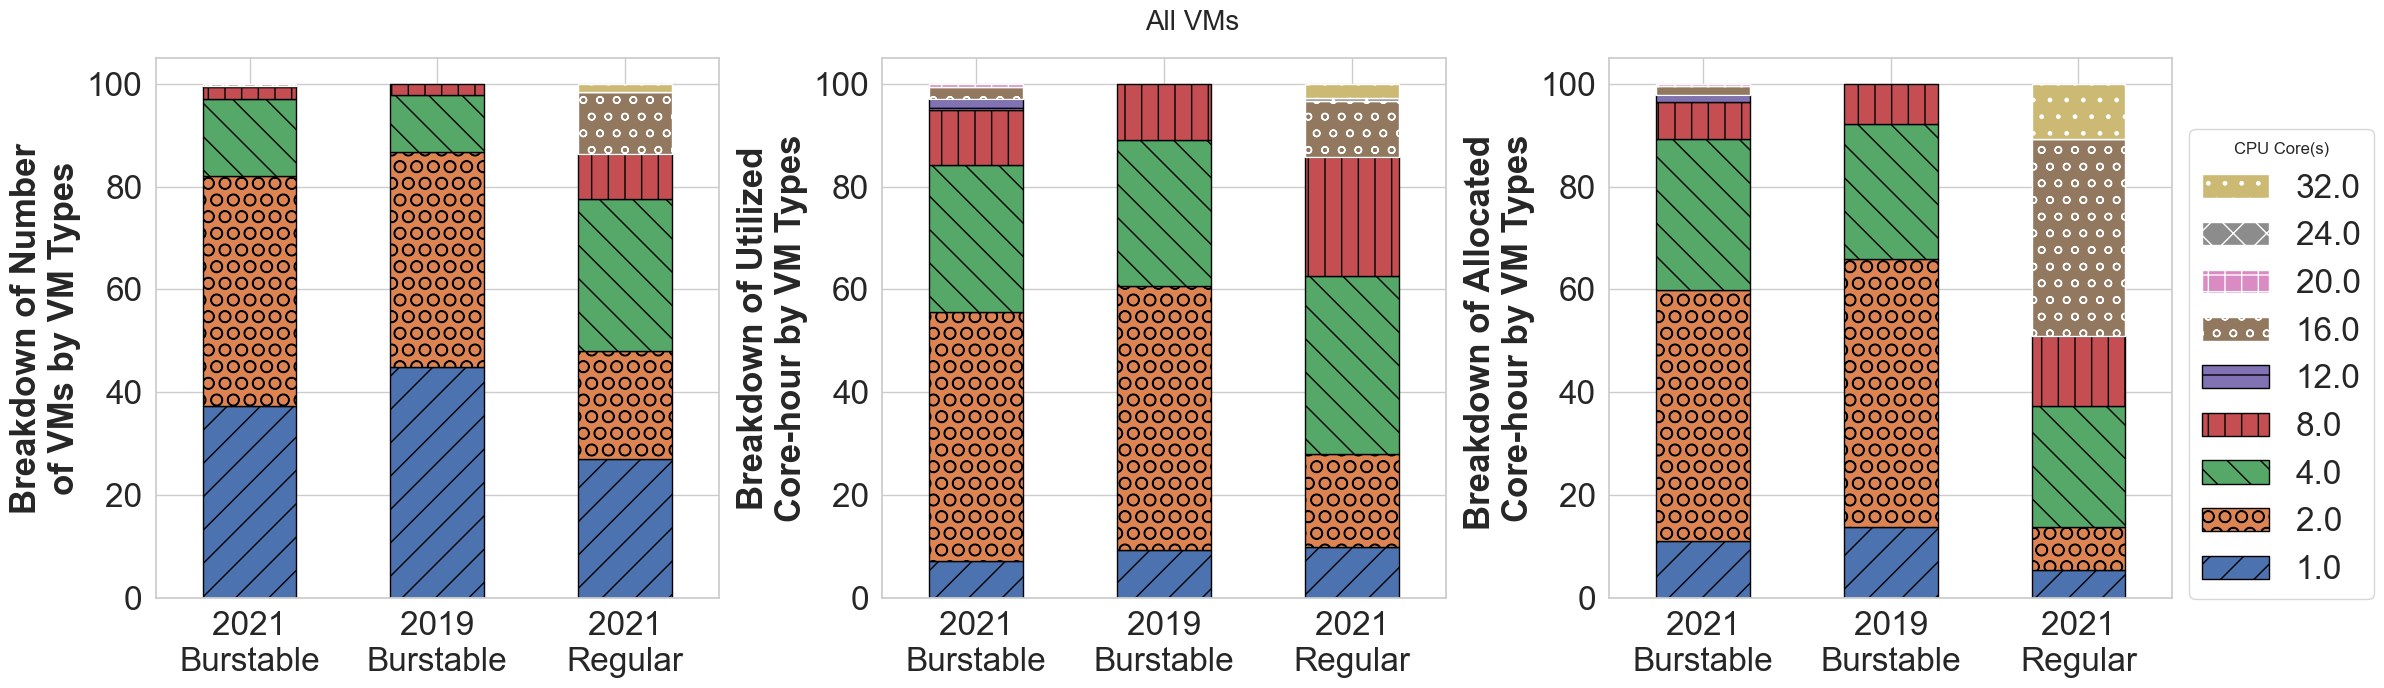

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap ranging from white to black
cmap = LinearSegmentedColormap.from_list('gray_spectrum', ['#f0f0f0', '#000000'], N=10)

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
hatches = ['/', 'O' , '\\', '|', '-', 'o', '+', 'x', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']
hatch_colors = ['#000000']*5 + ['#ffffff']*5
for idx, ylabel, feature in [(0, 'Breakdown of Number\nof VMs by VM Types', 'corecount'),
                              (1, 'Breakdown of Utilized\nCore-hour by VM Types', 'utilized_corehours_from_ns'),
                              (2, 'Breakdown of Allocated \nCore-hour by VM Types', 'allocated_corehours_from_ns')]:
    i, j, ftypes = 0, 0, [feature]
    if 'corecount' in feature:
        mydf = pd.concat({ds_name.replace('_', '\n').title(): trace_dataframes[ds_name].groupby('corecount')[ftypes].count() * 100 / trace_dataframes[ds_name][ftypes].count() for ds_name in
                     ['2021_burstable', '2019_burstable', '2021_regular']}, axis=1)
    else:
        mydf = pd.concat({ds_name.replace('_', '\n').title(): trace_dataframes[ds_name].groupby('corecount')[ftypes].sum() * 100 / trace_dataframes[ds_name][ftypes].sum() for ds_name in
                     ['2021_burstable', '2019_burstable', '2021_regular']}, axis=1)
    
    # mydf.T.plot.bar(stacked=True, ax=axs[idx], width=0.5, cmap=cmap) #grey colors
    mydf.T.plot.bar(stacked=True, ax=axs[idx], width=0.5) # colored
    denom = len(mydf.columns)
    while j < len(axs[idx].patches) // denom:
        for k in range(denom):
            axs[idx].patches[i + k].set_hatch(hatches[j % (len(axs[idx].patches) // denom)])
            axs[idx].patches[i + k].set_edgecolor(hatch_colors[j % len(hatch_colors)])
        i, j = i + denom, j + 1
    axs[idx].tick_params(axis='x', labelrotation=0)
    axs[idx].set_xticklabels([i.get_text().split(',')[0].strip('(') for i in axs[idx].get_xticklabels()])
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel(ylabel)
    axs[idx].legend().set_visible(False)

# Add legend to the last subplot
axs[-1].legend(plt.gca().get_legend_handles_labels()[0][::-1], plt.gca().get_legend_handles_labels()[1][::-1],
               fancybox=True, shadow=False, title='CPU Core(s)', bbox_to_anchor=(1, 0.9), ncol=1)
fig.suptitle('All VMs', fontsize = size)
plt.tight_layout()
plt.show()

# <a id='toc3_'></a>[Normalized Average CPU Utilization CDF](#toc0_)

In [9]:
for ds_name in ds_names:
    try:
        if 'burstable' in ds_name:
            trace_dataframes[ds_name]['norm_avg_avg_cpu_by_2Xbaseline'] = pd.read_csv(f'data/figures_processed_data/{ds_name}_norm_avg_avg_cpu_by_2Xbaseline.csv')['norm_avg_avg_cpu_by_2Xbaseline']
        else:
            trace_dataframes[ds_name]['norm_avg_avg_cpu_by_peakcpu'] = pd.read_csv(f'data/figures_processed_data/{ds_name}_norm_avg_avg_cpu_by_peakcpu.csv')['norm_avg_avg_cpu_by_peakcpu']
    except:
        if 'burstable' in ds_name:
            trace_dataframes[ds_name]['norm_avg_avg_cpu_by_2Xbaseline'] = 100*0.5*trace_dataframes[ds_name]['trace'].apply(np.mean)/trace_dataframes[ds_name]['baseline']
        else: # regular dataset
            trace_dataframes[ds_name]['norm_avg_avg_cpu_by_peakcpu'] = 100*trace_dataframes[ds_name]['trace'].apply(np.mean)/trace_dataframes[ds_name]['corecount']

(0.0, 60.0)

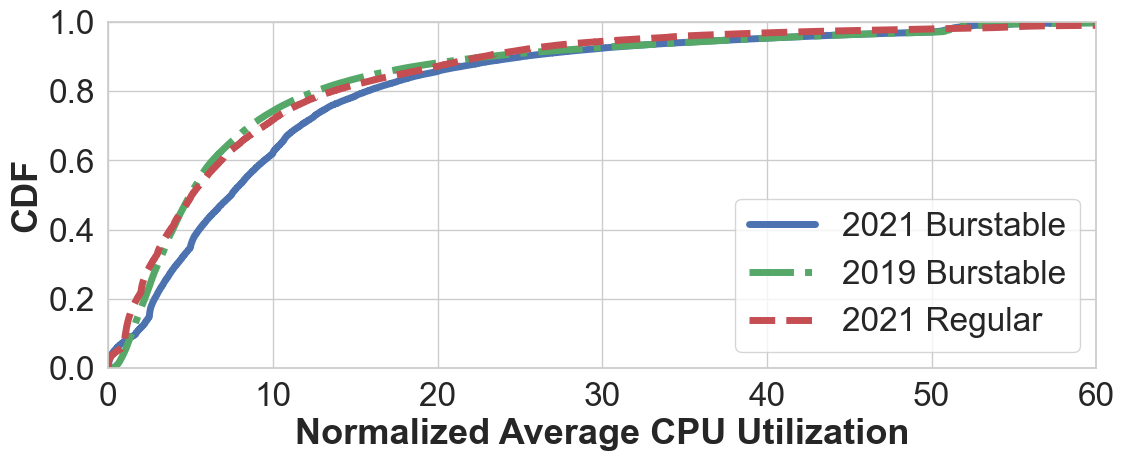

In [10]:
fig, ax = plt.subplots(figsize = (8.5*1.5, 3*1.5))
axs_per_ds = {}
for i, ds_name in enumerate(ds_names):
    if 'burstable' in ds_name:
        axs_per_ds[ds_name] = sns.ecdfplot(data = trace_dataframes[ds_name], x = 'norm_avg_avg_cpu_by_2Xbaseline', weights = 'num_samples', label = ds_name.replace('_',' ').title(), linestyle = ds_to_ls[ds_name], linewidth = 5, color = ds_to_color[ds_name], ax = ax)
    else:
        axs_per_ds[ds_name] = sns.ecdfplot(data = trace_dataframes[ds_name], x = 'norm_avg_avg_cpu_by_peakcpu', weights = 'num_samples', label = ds_name.replace('_',' ').title(), linestyle = ds_to_ls[ds_name], linewidth = 5, color = ds_to_color[ds_name], ax = ax)
plt.legend(loc = 'lower right')
plt.xlabel('Normalized Average CPU Utilization', fontsize = 1.3*size)
plt.ylabel('CDF', fontsize = 1.3*size)
plt.xlim(0, 60)

# <a id='toc4_'></a>[Kurtosis](#toc0_)

In [17]:
kurtosis_per_ds = {}
for ds_name in ds_names:
    try:
        kurtosis_per_ds[ds_name] = np.load(f'data/figures_processed_data/{ds_name}_kurtosis.npy', allow_pickle=True)
    except:
        temp = trace_dataframes[ds_name][trace_dataframes[ds_name]['trace'].apply(len) > 288]
        kurtosis_per_ds[ds_name] = temp['trace'].apply(kurtosis).values


Text(0, 0.5, 'CDF')

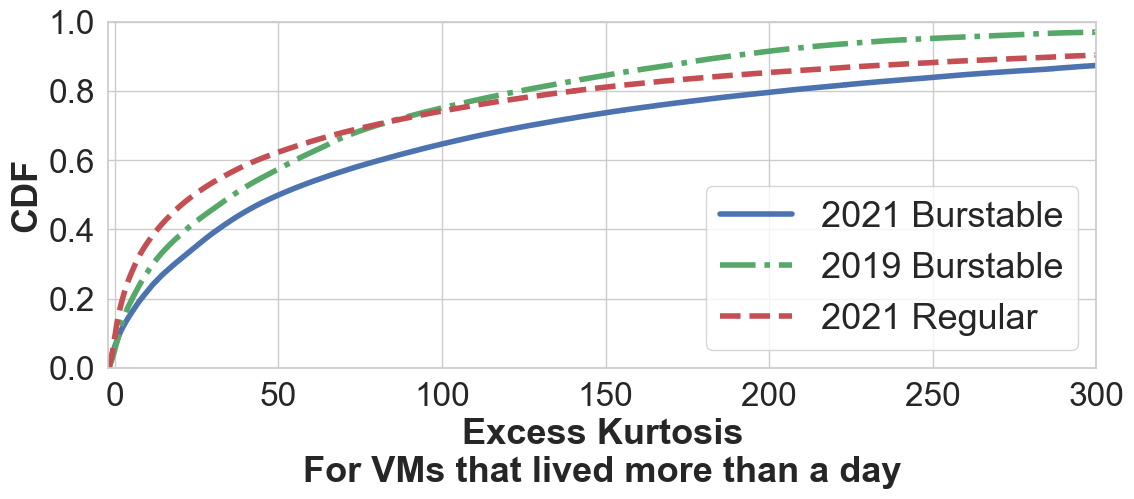

In [19]:
fig, ax = plt.subplots(figsize = (8.5*1.5, 3*1.5))
for idx, ds_name in enumerate(ds_names):
    sns.ecdfplot(list(kurtosis_per_ds[ds_name]), label = ds_name.replace('_', ' ').title(), ax = ax, lw = 4, linestyle = ds_to_ls[ds_name], color = ds_to_color[ds_name])
ax.legend(fontsize = size*1.3)
ax.set_xlim(-2, 300)
ax.set_xlabel('Excess Kurtosis\nFor VMs that lived more than a day', fontsize = size*1.3)
ax.set_ylabel('CDF', fontsize = size*1.3)

# <a id='toc5_'></a>[Kurtosis of a server packed with different BVM traces](#toc0_)

we used one of the examples in this repo. The paper used three large scale experiments for three different server sizes instead.

In [49]:
location = 'results/CLT/small_1_CLT_2021_burstable_2_86400_0.95_est_worst-fit_usage_10_48_0.01_0_True_2016'
result_df = pd.read_feather(f'{location}.feather')

In [64]:
temp = result_df['usage'].apply(kurtosis)
print("In this example experiment involving 10 servers, \nthe excess kurtosis values, which indicate the tailedness of aggregate CPU usage for each server, \nare as follows:\n{}".format(temp.values))

In this example experiment involving 10 servers, 
the excess kurtosis values, which indicate the tailedness of aggregate CPU usage for each server, 
are as follows:
[0.89397911 0.87906939 0.82207468 5.60840183 0.08523377 1.98101055
 0.32994695 0.71400911 0.58614357 1.55811797]


# <a id='toc6_'></a>[Breakdown of the Number of VMs and CPU-hours based on VM lifetimes](#toc0_)

In [20]:
# adding second_lifetime_label column
base_labels = ['< 1 hour', '1 hour to 12 hours', '12 hours to 1 day', '1 day to 3 days', '3 days <']
for ds_name in ['2021_burstable', '2021_regular']:
    bins = [-1, 11, 143, 287, 863, 8639]
    trace_dataframes[ds_name]['second_lifetime_label'] = pd.cut(trace_dataframes[ds_name]['num_samples'], bins = bins, labels = base_labels)

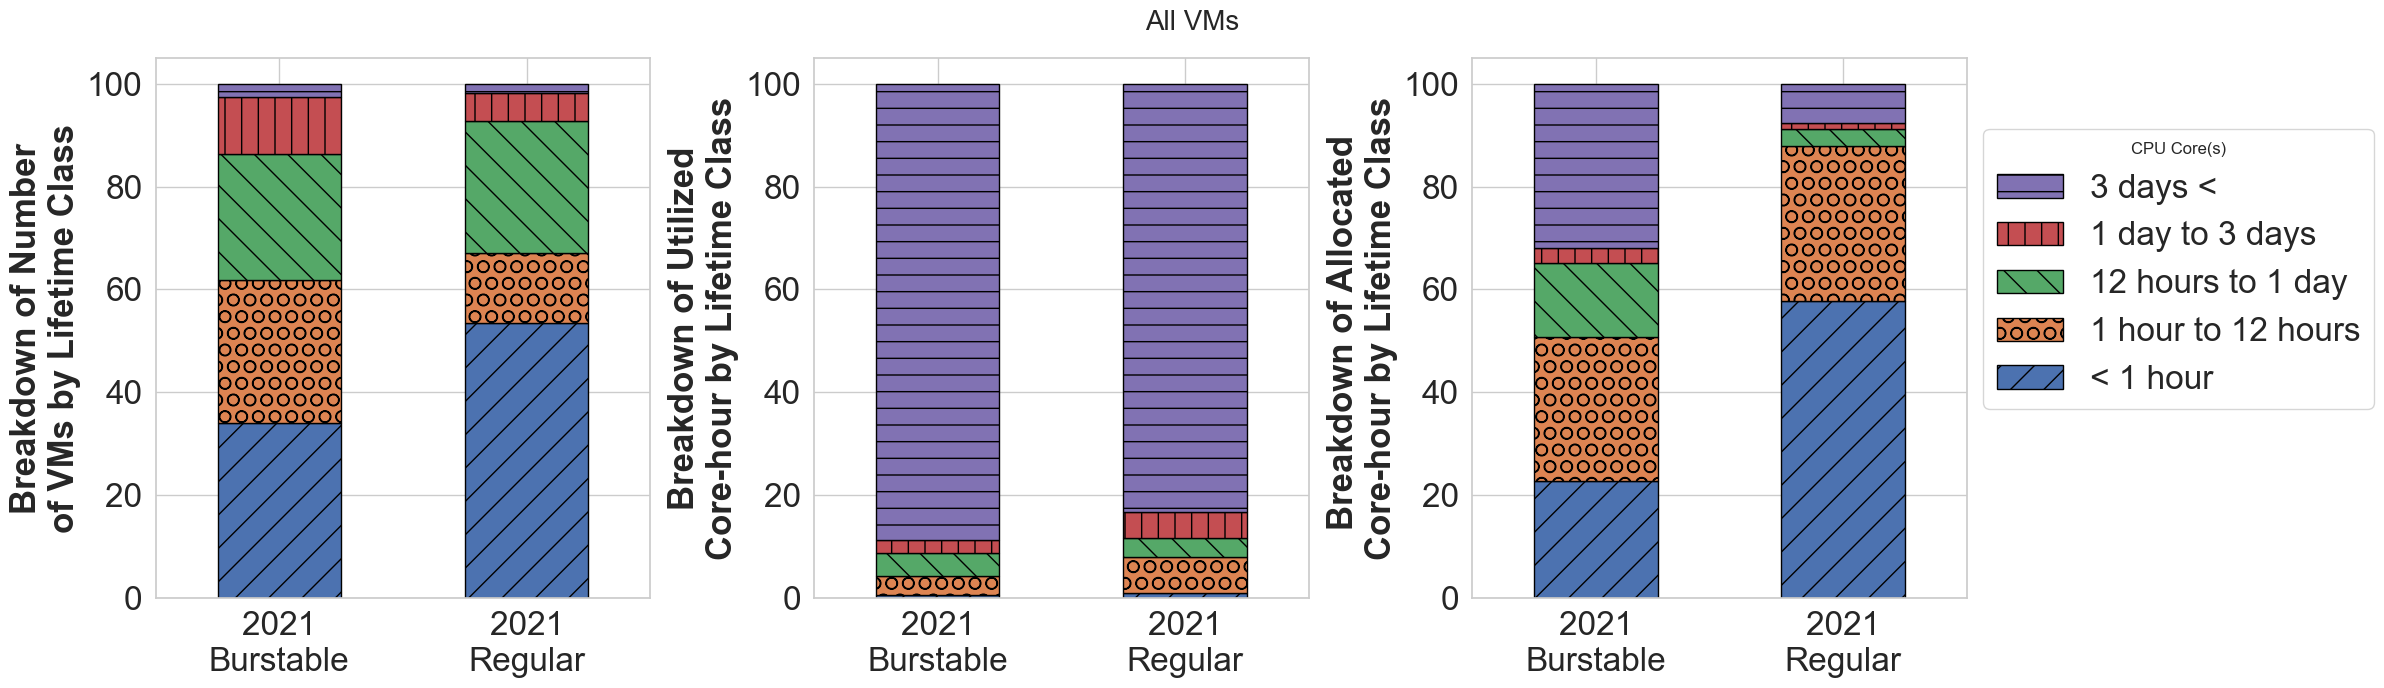

In [21]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap ranging from white to black
cmap = LinearSegmentedColormap.from_list('gray_spectrum', ['#f0f0f0', '#999999'], N=10)

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
hatches = ['/', 'O' , '\\', '|', '-', 'o', '+', 'x', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']
hatch_colors = ['#000000']*5 + ['#ffffff']*5
for idx, ylabel, feature in [(0, 'Breakdown of Number\nof VMs by Lifetime Class', 'second_lifetime_label'),
                              (1, 'Breakdown of Utilized\nCore-hour by Lifetime Class', 'utilized_corehours_from_ns'),
                              (2, 'Breakdown of Allocated \nCore-hour by Lifetime Class', 'allocated_corehours_from_ns')]:
    i, j, ftypes = 0, 0, [feature]
    if 'second_lifetime_label' in feature:
        mydf = pd.concat({ds_name.replace('_', '\n').title(): trace_dataframes[ds_name][ftypes[0]].value_counts() * 100 / len(trace_dataframes[ds_name]) for ds_name in
                     ['2021_burstable', '2021_regular']}, axis=1)
    else:
        mydf = pd.concat({ds_name.replace('_', '\n').title(): trace_dataframes[ds_name].groupby('second_lifetime_label')[ftypes].sum() * 100 / trace_dataframes[ds_name][ftypes].sum() for ds_name in
                     ['2021_burstable', '2021_regular']}, axis=1)
    
    # mydf.T.plot.bar(stacked=True, ax=axs[idx], width=0.5, cmap=cmap) # grey colored
    mydf.T.plot.bar(stacked=True, ax=axs[idx], width=0.5) # colored
    denom = len(mydf.columns)
    while j < len(axs[idx].patches) // denom:
        for k in range(denom):
            axs[idx].patches[i + k].set_hatch(hatches[j % (len(axs[idx].patches) // denom)])
            axs[idx].patches[i + k].set_edgecolor(hatch_colors[j % len(hatch_colors)])
        i, j = i + denom, j + 1
    axs[idx].tick_params(axis='x', labelrotation=0)
    axs[idx].set_xticklabels([i.get_text().split(',')[0].strip('(') for i in axs[idx].get_xticklabels()])
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel(ylabel)
    axs[idx].legend().set_visible(False)

# Add legend to the last subplot
axs[-1].legend(plt.gca().get_legend_handles_labels()[0][::-1], plt.gca().get_legend_handles_labels()[1][::-1],
               fancybox=True, shadow=False, title='CPU Core(s)', bbox_to_anchor=(1, 0.9), ncol=1)
fig.suptitle('All VMs', fontsize = size)
plt.tight_layout()
plt.show()


# <a id='toc7_'></a>[CDF of the Percentage of all Running VMs that are long-running at any 5-minute sampling point](#toc0_)

In [ ]:
# get the lifetime of active VMs at each time during the first 3 days:
ratio_long_to_all = {}
for ds_name in ds_names:
    try:
        ratio_long_to_all[ds_name] = np.load(f'data/figures_processed_data/{ds_name}_ratio_long_to_all.npy', allow_pickle=True)
    except:
        for time_idx in tqdm(range(0, 24*3*3600, 300)):
            avmids_per_time = trace_dataframes[ds_name][(trace_dataframes[ds_name].vmcreated <= time_idx) & (trace_dataframes[ds_name].vmdeleted > time_idx )].index.values
            temp = trace_dataframes[ds_name].loc[avmids_per_time]
            ratio_long_to_all[ds_name].append( len(temp[temp.num_samples > 288])/len(temp) )

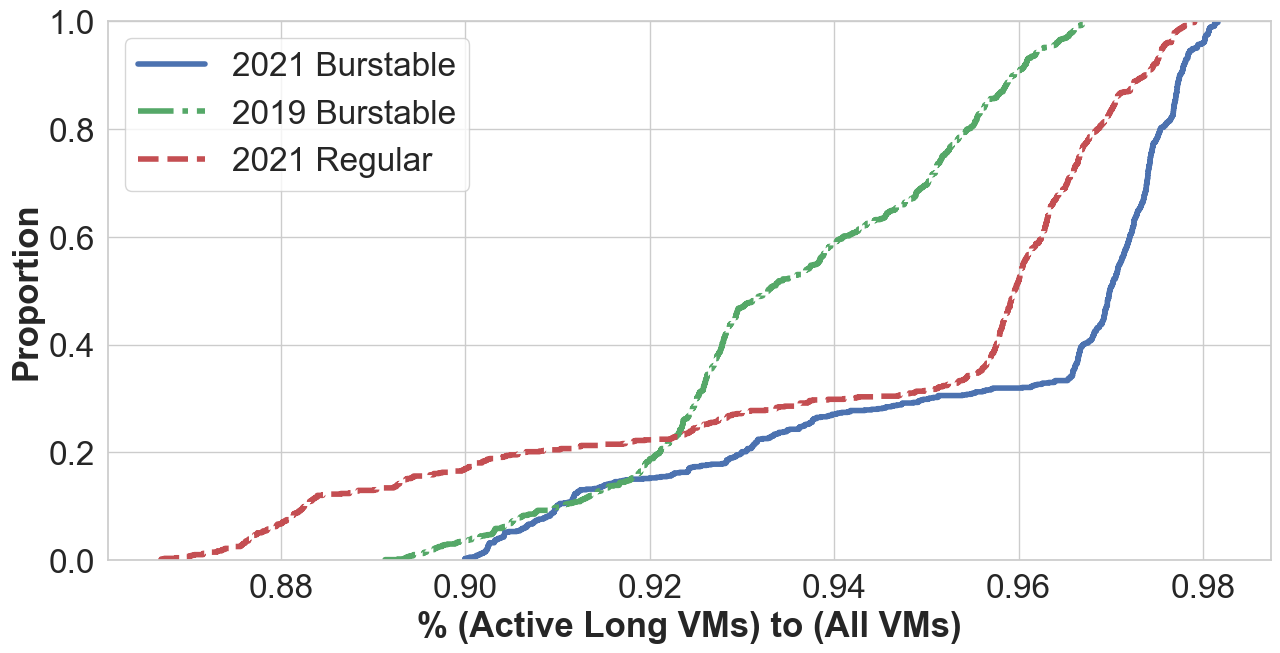

In [23]:
fig, ax = plt.subplots()
for idx, ds_name in enumerate(ds_names):
    sns.ecdfplot(ratio_long_to_all[ds_name], label = ds_name.replace('_', ' ').title(), ax = ax, lw = 4, linestyle = ds_to_ls[ds_name], color = ds_to_color[ds_name])
ax.set_ylabel('Proportion')
ax.set_xlabel('% (Active Long VMs) to (All VMs)')
ax.legend(loc = 2)

# <a id='toc8_'></a>[Comparing Server Capacity Violations and Utilization for different algorithms](#toc0_)

To replicate the graphs reported in the paper exactly, you will need the result files. These files are not included in this repository due to their large size.

In [30]:
df_per_algo = {}
server_capacity = 48
for algo, vm_arr_rate, first_model in [('audible', 269, '0.95'), ('rc', 115, 'rc-0.95'), ('oversubscription-azure', 49, '2X'), ('oversubscription-oracle', 242, '0.4X'), ('CLT', 278, '0.95')]:
    dfs = []
    for random_seed in range(777, 787):
        location = f"results/{algo}/small_{random_seed}_{algo}_2021_burstable_{vm_arr_rate}_87264_{first_model}_oracle_worst-fit_usage_756_{server_capacity}_0.01_0_True_2880"
        result_df = pd.read_feather(f'{location}.feather')
        dfs.append(result_df)
    df_per_algo[algo] = pd.concat(dfs, axis=0)

In [51]:
average_utilization_per_algorithm, violation_rate_per_algorithm, max_violation_magnitude_per_algorithm = {}, {}, {}
for algo, vm_arr_rate, first_model in [('audible', 269, '0.95'), ('rc', 115, 'rc-0.95'), ('oversubscription-azure', 49, '2X'), ('oversubscription-oracle', 242, '0.4X'), ('CLT', 278, '0.95')]:
    average_utilization_per_algorithm[algo] = 100*df_per_algo[algo]['usage'].apply(np.mean).values/server_capacity
    violation_rate_per_algorithm[algo] = df_per_algo[algo]['usage'].apply( lambda x: 100*len(x[x>server_capacity])/len(x) ).values
    temp = df_per_algo[algo]['usage'].apply( lambda x: np.max((100*x[x>server_capacity]/server_capacity) - 100, initial=0)).values
    max_violation_magnitude_per_algorithm[algo] = temp#[temp>=0] 


Text(0.5, 0, 'Average Utilization (%)')

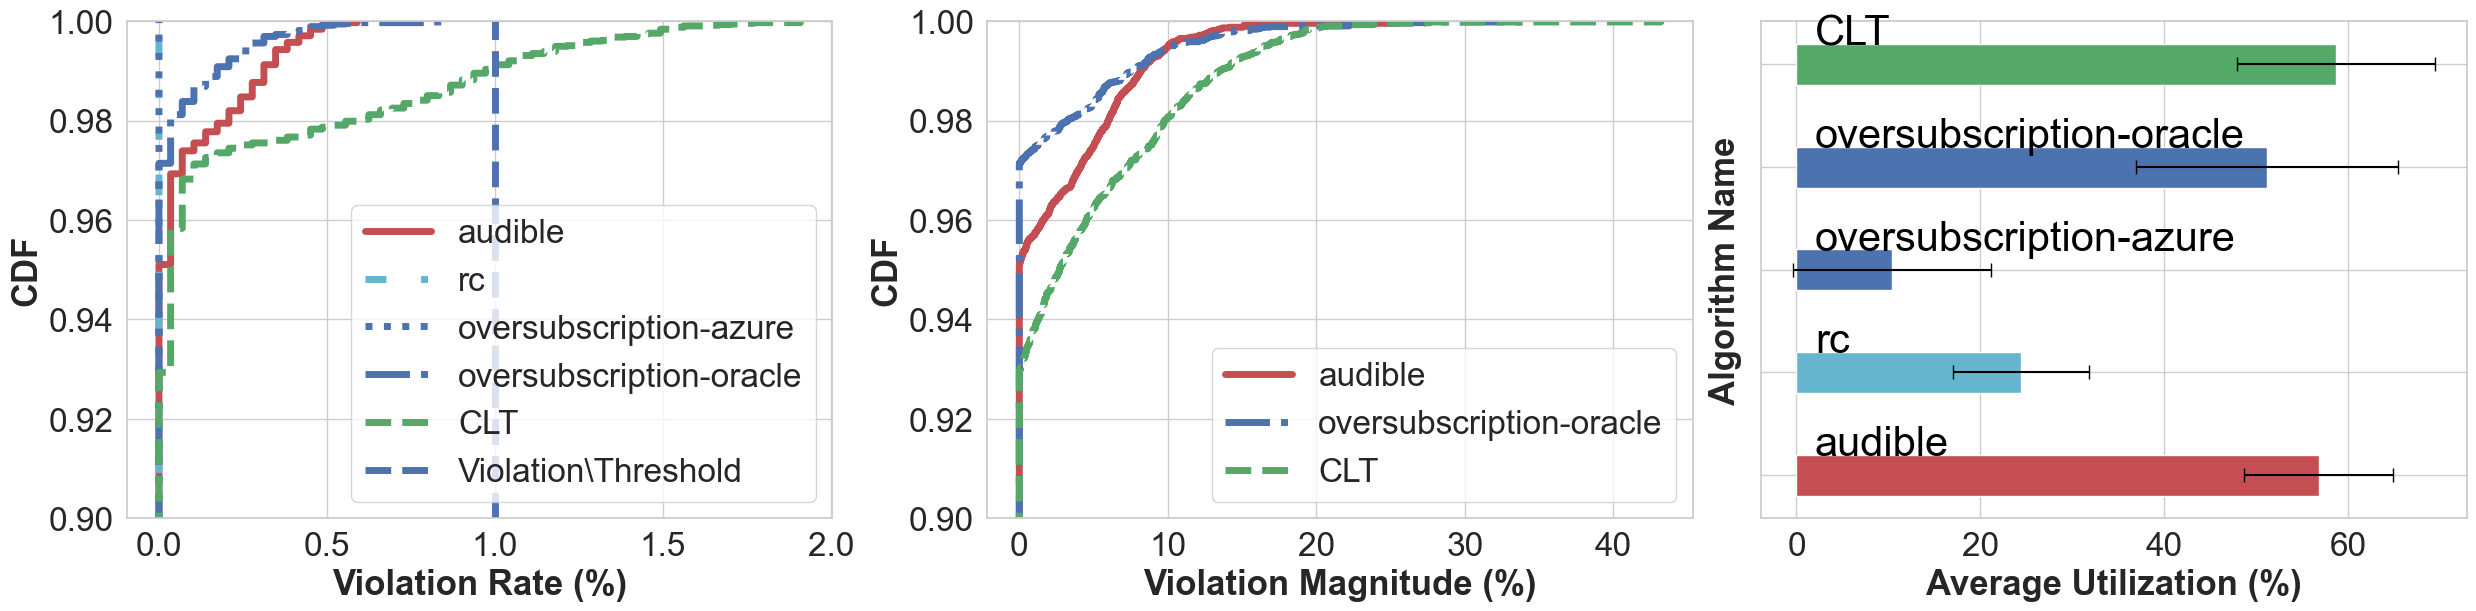

In [52]:
fig, axs = plt.subplots(1, 3, figsize = (8.5*2.9, 3*2), constrained_layout=True)
for algo in violation_rate_per_algorithm:
    # violation rate
    sns.ecdfplot(violation_rate_per_algorithm[algo], label = algo, color = algo_to_color[algo.lower()], ax = axs[0], lw = 5, ls = algo_to_ls[algo.lower()])
    axs[0].set_ylim(0.9, 1)
    # max violation Magnitude
    if sum(max_violation_magnitude_per_algorithm[algo]) != 0:
        sns.ecdfplot(max_violation_magnitude_per_algorithm[algo], label = algo, color = algo_to_color[algo.lower()], ax = axs[1], lw = 5, ls = algo_to_ls[algo.lower()])
    axs[1].set_ylim(0.9, 1)

axs[0].set_xlabel('Violation Rate (%)')
axs[0].set_ylabel('CDF')
axs[0].vlines(ymin = 0.9, ymax = 1, x = 1, ls = '--', lw = 5, label = 'Violation\Threshold')
axs[0].legend(loc = 4)

axs[1].set_xlabel('Violation Magnitude (%)')
axs[1].set_ylabel('CDF')
axs[1].legend(loc = 4)

# Average Utilization
means = {algo:np.mean(average_utilization_per_algorithm[algo]) for algo in average_utilization_per_algorithm}
ranges = [np.max(average_utilization_per_algorithm[algo]) - np.min(average_utilization_per_algorithm[algo]) for algo in average_utilization_per_algorithm]
bar_colors = [algo_to_color[algo.lower()] for algo in average_utilization_per_algorithm]
axs[2].barh(np.arange(len(means)), means.values(), xerr=ranges, capsize=5, color=bar_colors, ecolor='black', height = 0.4)
# axs[2].set_yticklabels(means.keys())
axs[2].set_yticklabels([])
for i, (algorithm_name, value) in enumerate(means.items()):
    axs[2].text(2, i + 0.3, algorithm_name.replace('\n', ' '), va='center', ha='left', color='black', fontsize=size*1.5)

# axs[2].tick_params(axis='y', direction='in', pad=-35)
axs[2].set_yticks(range(len(means)))
axs[2].set_ylabel('Algorithm Name')
axs[2].set_xlabel('Average Utilization (%)')
# fig.subplots_adjust(wspace=0.1)
# plt.tight_layout()

In Figure 9, which consists of multiple subplots, each subplot consistently displays nine bars. Within each subplot, one of these nine bars is constructed using the data we have gathered. This particular bar represents the outcomes of simulations detailing the highest arrival rate that the Audible algorithm can manage, provided that 1% violation rate is the acceptable threshold and the server's capacity is at 48 cores.